In [187]:
from simulate import *

from datetime import datetime
from os import getcwd, makedirs, path
from random import randrange
from shutil import copyfile
from time import time
from PIL import Image

from IPython.display import HTML


# Image preprocessing
binary_threshold = 10

# Connected components
connection_radius = 1

# Latice and region creation
lattice_radius = 25
lattice_stride = 25
min_component_size = 2

# Simulation
num_free_cells = 300
neighborhood_radius = 2
max_iterations = 10
num_simulations = 100

# Meta
verbose = True

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'%.3f'

In [188]:
# all checkered
# half checkered, half repulse (or attract)
#   left/right
#   up/down
# half repulse, half attract
# block
# square in middle
# circle in middle

# Increase attach change when on vein
# Look at edge effects
# Simulate 3d veins?

def checkered(square_size, height, width, value=255):
    zeros = [0] * square_size
    ones = [1] * square_size
    checker = np.array([zeros + ones] * square_size + [ones + zeros] * square_size) * value
    
    h = height // square_size // 2
    w = width // square_size // 2
    return np.tile(checker, (h, w))

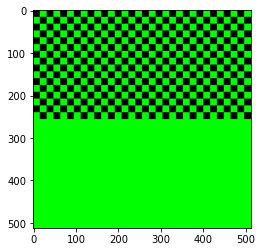

In [189]:
image_size = 512
image_size_half = image_size // 2
check_size = image_size // 32

fake_image_data = np.zeros((image_size, image_size, 3))

# Vein above void
# fake_image_data[:image_size_half, :, 1] = 255

# Vein below void
# fake_image_data[image_size_half:, :, 1] = 255

# Vein then void
# fake_image_data[:, :image_size_half, 1] = 255

# Void then vein
# fake_image_data[:, image_size_half:, 1] = 255

# Checkered
# fake_image_data[:, :, 1] = checkered(check_size, image_size, image_size)

# Checkered above void
# fake_image_data[:image_size_half, :, 1] = checkered(check_size, image_size_half, image_size)

# Checkered above vein
fake_image_data[:, :, 1] = 255
fake_image_data[:image_size_half, :, 1] = checkered(check_size, image_size_half, image_size)

image = Image.fromarray(fake_image_data.astype("uint8"), "RGB")

plt.imshow(image);

In [190]:
new_dirname = path.join(getcwd(), datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
makedirs(new_dirname)

# Copy the configuration file to the directory so that we can see
# the values that generated the outputs
copyfile("./configuration.py", path.join(new_dirname, "configuration.py"))

# Force the image to be square
# TODO: ask Ryan if we can expect most images to be about 512x512
square_image = image.resize((512, 512))

start = time()
binary_image = binarize_and_threshold_image(square_image, binary_threshold)
if verbose:
    print(binary_image.shape, binary_image.dtype)
    print(f"Time to binarize the input image: {time() - start:0.3f}s\n")

start = time()
adj_list = create_matrix_from_adjacency_list(binary_image, connection_radius)
if verbose:
    print("Number of vertices in graph:", len(adj_list))
    print(f"Time to create graph: {time() - start:0.3f}s\n")

start = time()
components = find_connected_components(adj_list)
num_components = len(components)
if verbose:
    print("Number of components:", num_components)
    print(f"Time to compute connected components: {time() - start:0.3f}s\n")

start = time()
lattice = count_components_per_region(
    binary_image.shape,
    lattice_radius,
    lattice_stride,
    components,
    min_component_size,
)
if verbose:
    print(f"Time to create regions: {time() - start:0.3f}s\n")

start = time()
brightness = compute_brightness_per_region(square_image, lattice_stride)
regions = compute_region_push_pull_score(lattice, brightness)
if verbose:
    print(f"Time to create regions: {time() - start:0.3f}s\n")

(512, 512) uint8
Time to binarize the input image: 0.001s

Number of vertices in graph: 262144
Time to create graph: 20.621s

Number of components: 497
Time to compute connected components: 0.764s

Time to create regions: 2.448s

Time to create regions: 0.007s



In [191]:
start = time()
final_panes, animation_data = run_animations(
    regions,
    neighborhood_radius,
    max_iterations,
    num_simulations,
    num_free_cells,
)
if verbose:
    print(f"Time to run animations: {time() - start:0.3f}s\n")

Time to run animations: 30.358s



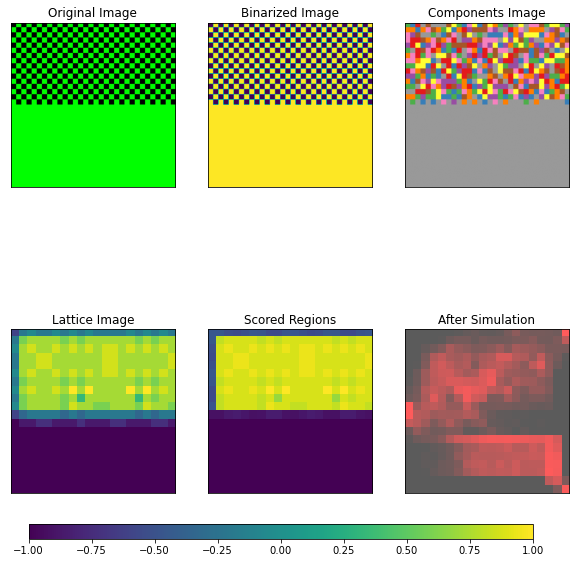

In [192]:
plot_figures(
    components,
    square_image,
    final_panes,
    binary_image,
    lattice,
    regions,
    new_dirname,
)

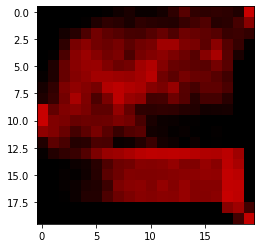

In [193]:
animation = generate_animation_image(animation_data, new_dirname);

In [194]:
HTML(animation.to_jshtml())

In [195]:
brightness.min(), brightness.max()

(-0.07840000000000003, 1.0)

In [196]:
lattice.min(), lattice.max()

(1, 16)

In [197]:
regions.min(), regions.max()

(-1.0, 1.0)

In [198]:
np.amax(lattice)

16

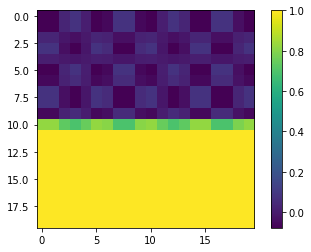

In [199]:
plt.imshow(brightness)
plt.colorbar()

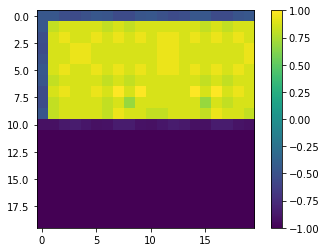

In [200]:
plt.imshow(regions)
plt.colorbar()